## Current baseline:

In [ ]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [1]:
import matplotlib.pyplot as plt

In [2]:
from problem import get_train_data, get_test_data, WeightedClassificationError

In [3]:
import numpy as np
import tensorflow as tf
from time import time
import pandas as pd
import math

In [4]:
videos_train, labels_train = get_train_data()

In [5]:
len(videos_train)

177

## TOOLS

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize frames in a video.
# 3 rows and 10 columns for 30 frames of a video.
#
# idx=0
# vid= X_for_classifier[idx][:,:,:]
# plot_slices(3, 10, 224, 224, l)
# print(int_to_class(train_labels[idx]))

In [7]:
from PIL import Image

#####CLEEEEEEEAN !!!
def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize((224,224))
        res.append(np.array(resized_img))
    return np.array(res)

In [8]:
#Filtering only class A and class H
def filter(filters,x,y):
    rx=x.copy()
    ry=y.copy()
    ry=list(ry)
    
    df = pd.DataFrame({'labels':ry,'features':rx})
    df = df[~df.labels.isin(filters)]
    ry = df['labels'].tolist()
    rx = df['features'].tolist()
    
    return rx,ry

In [9]:
filters= ['B','C','D','E','F','G']
a,b=filter(filters,videos_train, labels_train)
videos_train= a
labels_train= np.array(b)

In [10]:
#transforming the data set: each observation now correponds the nth observation
def nth_frame(videolist, n):
    n = 300
    nth_frames=[]
    i=0
    for video in videolist:
        i+=1
        time= video.frame_times[n-1]
        frame= video.read_frame(time)
        nth_frames.append(frame)
    return nth_frames

In [11]:
def create_dataset(startFrame, endFrame, x, y):
    xres= nth_frame(x,startFrame)
    yres= np.array(y)
    for i in range(startFrame+1, endFrame+1):
        temp= nth_frame(x,i)
        xres+= temp
        yres= np.append(yres,np.array(y))
    return xres,yres

In [12]:
builtx, builty= create_dataset(300,300, videos_train, labels_train)

In [13]:
X_for_classifier=np.array(builtx)

In [14]:
X_for_classifier=resize_frames(X_for_classifier)
y_for_classifier= builty

In [15]:
X_for_classifier[None, ...].shape

(1, 62, 224, 224)

In [16]:
#temp fix to make it work with MobileNetV2

grayscale_batch=X_for_classifier
rgb_batch = np.repeat(grayscale_batch[...,np.newaxis], 3, -1)


In [17]:
X_for_classifier= rgb_batch

In [18]:
X_for_classifier.shape

(62, 224, 224, 3)

In [19]:
#test after transformation: prints all images of dataset
#for i in range(0,176):
#    plt.imshow(X_for_classifier[i], cmap='gray')
#    title_obj = plt.title(y_for_classifier[i]) 
#    plt.axis('off')
#    plt.show()


In [20]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':0,
        'C':0,
        'D':0,
        'E':1,
        'F':1,
        'G':1,
        'H':1,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")
 

In [21]:
func=np.vectorize(class_to_int)
y_for_classifier=func(y_for_classifier)

In [22]:
y_for_classifier

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [23]:

#import numpy as np


#class VideoClassifier(object):
#    def __init__(self):
#        pass

#    def fit(self, videos: list, y, pred_time: float):
#        classes = ["A", "B", "C", "D", "E", "F", "G", "H"]
#        self.n_classes = len(classes)
#        print(type(self))
#        pass

#    def predict(self, videos: list, pred_time: float):
#        proba = np.random.rand(len(videos), self.n_classes)
#        proba /= proba.sum(axis=1)[:, np.newaxis]
#        return proba



## Data Augmentation with Keras ImageDataGenerator

In [52]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1./255, 
        rotation_range=30, fill_mode='nearest'
        #width_shift_range=0.1, height_shift_range=0.1,
        #horizontal_flip=True,
        #vertical_flip=True,
        #brightness_range=[0.8,1.2] #above 1 light , below darkens
)

In [53]:
zero=X_for_classifier[0:1]

In [54]:
zero[0][0][0]

array([5, 5, 5], dtype=uint8)

(-0.5, 223.5, 223.5, -0.5)

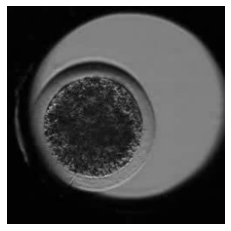

In [55]:
plt.imshow(zero[0])
plt.axis('off')

In [56]:
zero[0].shape

(224, 224, 3)

In [57]:
zeroaug=datagen.flow(zero, batch_size=1)

hello
hello
hello


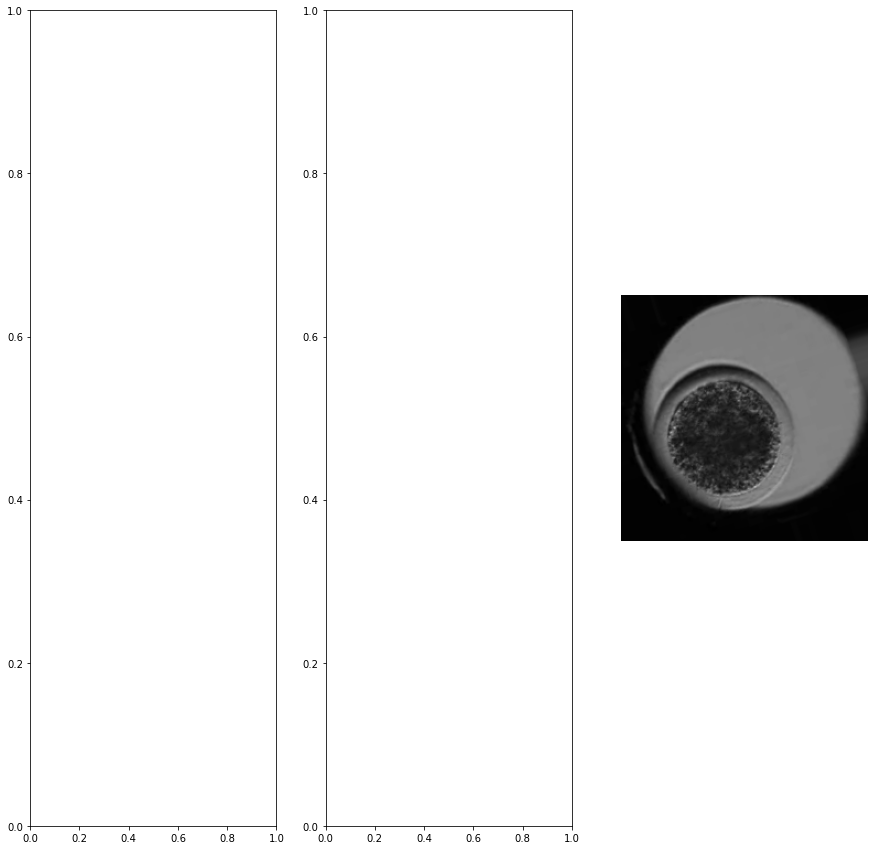

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

for i in range(3):
    image= next(zeroaug)[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    print("hello")

In [59]:
img= zero

In [ ]:
# ImageDataGenerator flipping
datagen =  tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

# iterator
aug_iter = datagen.flow(img, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

In [60]:
XY_classifier_augmented= datagen.flow(X_for_classifier, y_for_classifier, batch_size=32)

In [61]:
(next(XY_classifier_augmented))[1]

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0])

(224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

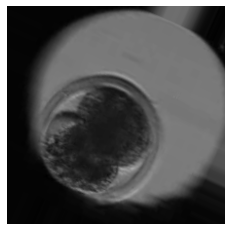

In [62]:
batch= next(XY_classifier_augmented)[0]
image=batch[2].astype('uint8')
print(image.shape)
plt.imshow(image)
plt.axis('off')

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

#for i in :

    # convert to unsigned integers
batch = next(XY_classifier_augmented)[0].astype('uint8')
 
    # plot image
    #ax[i].
for image in batch:
    plt.imshow(image)
    plt.axis('off')

## new Baseline test

### predefined pred times:

 ensuring that only frames up to pred_times are used for model training and testing. None is the whole 300 frames.

In [32]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94, None]

### Build the model

In [33]:
# Image shape for classifier
IMG_SHAPE = (224,224,3)

# Building of a classification model
base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
    )
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation="sigmoid")
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [63]:
# Uncomment this line to fit the classifier

model.fit(XY_classifier_augmented, epochs=100)

#model.fit(X_for_classifier,y_for_classifier, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 33ms/step - loss: 0.4615 - sparse_categorical_accuracy: 0.7742
Epoch 2/100
2/2 [==============================] - 0s 168ms/step - loss: 0.4409 - sparse_categorical_accuracy: 0.8065
Epoch 3/100
2/2 [==============================] - 0s 185ms/step - loss: 0.4626 - sparse_categorical_accuracy: 0.7903
Epoch 4/100
2/2 [==============================] - 0s 182ms/step - loss: 0.4402 - sparse_categorical_accuracy: 0.8226
Epoch 5/100
2/2 [==============================] - 0s 164ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.7581
Epoch 6/100
2/2 [==============================] - 0s 162ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.7581
Epoch 7/100
2/2 [==============================] - 0s 181ms/step - loss: 0.4478 - sparse_categorical_accuracy: 0.8226
Epoch 8/100
2/2 [==============================] - 0s 187ms/step - loss: 0.4178 - sparse_categorical_accuracy: 0.8226
Epoch 9/100
2/2 [==============================] - 0s 189

In [64]:
# Uncomment this cell to Load a previously saved model
#MODEL_NAME_FOR_PREDICTION = "classifier3"
#model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, MODEL_NAME_FOR_PREDICTION))

In [65]:
def predict_image(image, model):
    image = Image.fromarray(image)
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)

### Loading test data

In [66]:
videos_test, labels_test  = get_test_data()

In [67]:
videos_test, labels_test=filter(filters,videos_test, labels_test)



In [68]:
builtx, builty= create_dataset(300,300, videos_test, labels_test)

In [69]:
Xtest_for_classifier = resize_frames(builtx)
ytest_for_classifier = np.array(builty)

In [70]:
ytest_for_classifier

array(['A', 'A', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'A',
       'A', 'A', 'A', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'A', 'H',
       'H'], dtype='<U1')

In [71]:
grayscale_batch=Xtest_for_classifier
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)

In [72]:
ytest_for_classifier=func(ytest_for_classifier)

In [73]:
ytest_for_classifier

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1])

In [74]:
Xtest_for_classifier= rgb_batch

In [75]:
Xtest_for_classifier.shape

(27, 224, 224, 3)

In [76]:
loss, accuracy = model.evaluate(Xtest_for_classifier, ytest_for_classifier)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 234ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.7037
Test accuracy : 0.7037037014961243


In [77]:
preds = model.predict(Xtest_for_classifier)
preds = np.argmax(preds, axis=1)
preds

1/1 [==============================] - 0s 19ms/step


array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [78]:
ytest_for_classifier

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1])

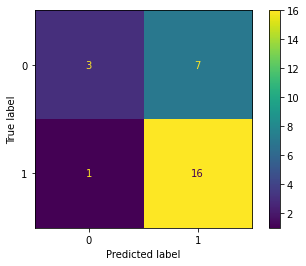

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(ytest_for_classifier, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [80]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']


In [81]:
print(classification_report(ytest_for_classifier, preds,labels=[0,1]))

              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.70      0.94      0.80        17

    accuracy                           0.70        27
   macro avg       0.72      0.62      0.61        27
weighted avg       0.72      0.70      0.66        27

